In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="7WDcRR7o9Dze5mRQltRg")
project = rf.workspace("dream-vj9o9").project("tobacco-segmentation-yn65w")
version = project.version(4)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to tobacco-segmentation-4 in yolov8:: 100%|██████████| 468/468 [00:00<00:00, 6092.17it/s]


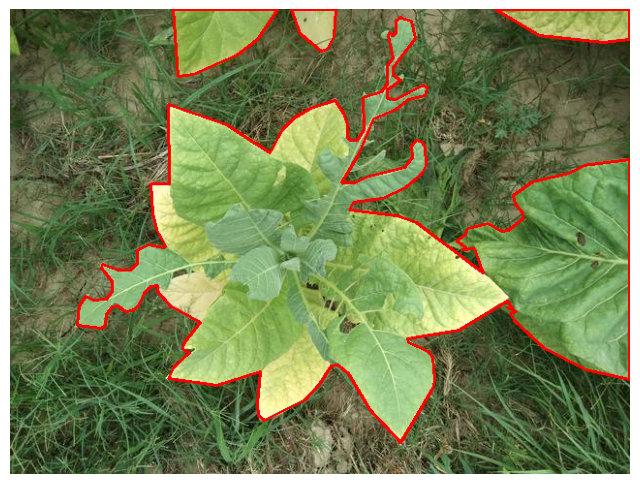

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define file paths
image_path = "/kaggle/working/tobacco-segmentation-4/train/images/tobacco_0251_jpg.rf.33207206762f99d9705271df0b468791.jpg"
label_path = "/kaggle/working/tobacco-segmentation-4/train/labels/tobacco_0251_jpg.rf.33207206762f99d9705271df0b468791.txt"

# Read the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Read the label file
with open(label_path, "r") as f:
    lines = f.readlines()

height, width, _ = image.shape

# Parse segmentation coordinates
for line in lines:
    parts = line.strip().split()
    class_id = int(parts[0])  # First value is the class ID
    points = np.array(parts[1:], dtype=np.float32).reshape(-1, 2)

    # Convert normalized coordinates to image dimensions
    points[:, 0] *= width  # Scale X coordinates
    points[:, 1] *= height  # Scale Y coordinates

    # Convert to integer format for drawing
    points = points.astype(np.int32)

    # Draw segmentation
    cv2.polylines(image, [points], isClosed=True, color=(255, 0, 0), thickness=2)
    # cv2.fillPoly(image, [points], color=(0, 255, 0))  # Transparent fill

# Show the image with segmentation
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()


In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 9.7 MB/s eta 0:00:00a 0:00:01


In [9]:
import os

# Define the content of data.yaml
yaml_content = """names:
  - tobacco
nc: 1
train: ../train/images
val: ../train/images  # Using train set for validation since valid set is missing
"""

# Define the path to save data.yaml
yaml_path = "/kaggle/working/tobacco-segmentation-4/data.yaml"

# Create necessary directories if they don't exist
os.makedirs(os.path.dirname(yaml_path), exist_ok=True)

# Write data.yaml file
with open(yaml_path, "w") as file:
    file.write(yaml_content)

print(f"✅ data.yaml created at {yaml_path}")




✅ data.yaml created at /kaggle/working/tobacco-segmentation-4/data.yaml


In [17]:
from ultralytics import YOLO
import torch

# Free up GPU memory
torch.cuda.empty_cache()

# Use a smaller model to avoid OOM errors
model = YOLO("yolov8l-seg.pt")

# Train the model with optimized settings and augmentations
model.train(
    data="/kaggle/working/tobacco-segmentation-4/data.yaml",
    epochs=100,
    batch=2,  # 🔥 Lower batch size (try 1 if needed)
    imgsz=640,
    workers=2,
    device="cuda",

    # Augmentations for better generalization
    hsv_h=0.015,  # Random hue shift
    hsv_s=0.7,  # Random saturation shift
    hsv_v=0.4,  # Random brightness shift
    flipud=0.5,  # Random vertical flip
    fliplr=0.5,  # Random horizontal flip
    mosaic=1.0,  # Use mosaic augmentation
    mixup=0.2,  # Mixup augmentation for blending images
    degrees=10,  # Random rotation
    translate=0.1,  # Random translation
    scale=0.5,  # Random scaling
    shear=2,  # Random shearing
)

print("✅ Training started successfully with augmentations!")


Ultralytics 8.3.83 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8l-seg.pt, data=/kaggle/working/tobacco-segmentation-4/data.yaml, epochs=100, time=None, patience=100, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=2, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

train: Scanning /kaggle/working/tobacco-segmentation-4/train/labels.cache... 231 images, 0 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/tobacco-segmentation-4/train/labels.cache... 231 images, 0 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/segment/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.68G      1.059      2.363      2.212      1.449          4        640: 100%|██████████| 116/116 [00:19<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.06it/s]

                   all        231        364      0.337       0.64      0.367      0.164      0.343      0.643      0.404       0.25



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.36G      1.364       2.16      2.068       1.67          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.08it/s]


                   all        231        364    0.00121      0.209   0.000745   0.000324    0.00123      0.212   0.000765    0.00019

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.39G      1.669      2.215      1.898      1.881          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.36it/s]


                   all        231        364     0.0052      0.505    0.00387    0.00156    0.00608      0.588    0.00492    0.00217

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.39G      1.569      2.191      1.707      1.779          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.21it/s]


                   all        231        364     0.0164       0.72     0.0148    0.00562     0.0166      0.723     0.0149    0.00752

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.38G      1.391      1.816       1.49      1.666          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.35it/s]


                   all        231        364     0.0287      0.541     0.0245     0.0117     0.0314      0.588     0.0262     0.0157

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.37G      1.433      2.019      1.564      1.677         12        640: 100%|██████████| 116/116 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.49it/s]


                   all        231        364      0.661        0.5      0.566      0.325      0.677        0.5      0.578      0.405

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.38G      1.325      2.013      1.492      1.568          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.11it/s]


                   all        231        364      0.682      0.734      0.776      0.502      0.677      0.728      0.751      0.618

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.42G      1.306      2.039      1.439      1.572          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.03it/s]


                   all        231        364      0.711      0.736      0.775      0.502      0.705      0.736      0.766      0.593

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.37G      1.155      1.881      1.368      1.466          6        640: 100%|██████████| 116/116 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.40it/s]


                   all        231        364      0.845      0.823      0.868      0.647      0.824      0.835      0.849      0.669

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.36G       1.12      1.907       1.27      1.432          5        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.53it/s]

                   all        231        364      0.726      0.846      0.845      0.659      0.835      0.722      0.824      0.704



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.38G       1.13      1.746      1.252      1.449          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.59it/s]

                   all        231        364      0.899      0.821      0.889      0.686      0.893      0.816      0.867       0.73



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.39G      1.118      1.755      1.272      1.419          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.46it/s]

                   all        231        364      0.549      0.709      0.511      0.366      0.546      0.706      0.504      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.38G      1.041      2.044      1.218      1.396          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.52it/s]

                   all        231        364      0.749      0.852      0.822       0.62      0.749      0.852      0.814      0.682



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.35G      1.011       1.83      1.177      1.356          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.54it/s]

                   all        231        364      0.832       0.83      0.875       0.67      0.829      0.827      0.858      0.722



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.36G     0.9397      1.707      1.106       1.29          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.52it/s]


                   all        231        364      0.905      0.794      0.888      0.659      0.857      0.841       0.87      0.703

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.36G     0.9699      1.759      1.135      1.319          5        640: 100%|██████████| 116/116 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.54it/s]

                   all        231        364      0.816       0.86      0.889      0.708      0.815      0.863      0.872      0.761



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.4G     0.9437      1.804       1.12      1.325          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.58it/s]

                   all        231        364       0.87      0.861        0.9      0.744       0.86      0.857      0.877      0.752



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.36G     0.8826      1.723      1.033      1.242          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.53it/s]

                   all        231        364      0.902      0.806       0.89       0.73      0.892      0.798      0.869      0.751



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.36G      0.919      1.682      1.069      1.313          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.57it/s]

                   all        231        364      0.905      0.885      0.906      0.721      0.902      0.882      0.894      0.759



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.38G     0.8425      1.657     0.9755      1.244          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.55it/s]

                   all        231        364      0.921      0.865      0.906      0.777      0.919      0.869      0.898      0.793



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.35G     0.8914      1.767      1.034      1.272          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.61it/s]

                   all        231        364      0.902      0.876      0.898      0.717      0.902      0.876      0.891      0.784



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.38G     0.8975       1.71      1.024      1.267          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.66it/s]

                   all        231        364      0.927      0.849      0.908      0.753      0.931      0.846      0.891      0.784



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.38G     0.9182      1.809       1.05      1.279          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.59it/s]

                   all        231        364      0.909      0.877        0.9      0.767      0.906      0.875      0.881      0.769



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.38G     0.8374       1.58     0.9524      1.231          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.60it/s]

                   all        231        364      0.924      0.854      0.911      0.776      0.917      0.849       0.89      0.756



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.39G     0.8839      1.691     0.9902      1.287          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.56it/s]

                   all        231        364      0.947       0.86       0.91      0.792      0.941      0.854      0.891      0.788



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.36G     0.8255      1.628     0.9269      1.222          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.58it/s]

                   all        231        364      0.907      0.887      0.902      0.773      0.905      0.863      0.881      0.765



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.42G     0.8612      1.694      1.004      1.259          6        640: 100%|██████████| 116/116 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.58it/s]

                   all        231        364      0.924      0.906      0.918      0.792      0.922      0.903      0.902      0.768



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.38G     0.8231      1.756     0.9689      1.214          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.41it/s]

                   all        231        364      0.938       0.89      0.906      0.771      0.938       0.89      0.898      0.773



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.38G     0.8214      1.725     0.9601      1.238          8        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.58it/s]

                   all        231        364      0.938       0.87      0.911      0.805      0.941      0.873      0.904      0.809



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.38G     0.7829      1.753     0.9331      1.212          5        640: 100%|██████████| 116/116 [00:18<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.60it/s]

                   all        231        364      0.919      0.887       0.92      0.808      0.875      0.846       0.89      0.795



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.38G     0.8293      1.683     0.9685      1.223          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.54it/s]

                   all        231        364      0.882      0.907      0.913      0.796      0.915      0.831      0.888      0.753



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.36G     0.7932       1.64      0.934      1.189          8        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.56it/s]

                   all        231        364      0.932      0.866      0.916      0.788      0.939      0.863      0.903      0.805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.38G     0.7696      1.696     0.9143      1.191          5        640: 100%|██████████| 116/116 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.54it/s]

                   all        231        364      0.934      0.879      0.919      0.834      0.931      0.876      0.903      0.797



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.39G     0.7888      1.579      0.911      1.209          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]

                   all        231        364      0.885      0.904       0.91      0.794      0.882      0.903      0.894      0.777



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.35G     0.7698      1.592     0.9124      1.196          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]

                   all        231        364      0.916      0.866      0.908      0.794      0.913      0.863      0.889       0.79



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.38G     0.7485      1.516     0.8781      1.196          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]

                   all        231        364      0.954      0.862      0.918      0.818      0.951      0.865      0.903      0.805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.36G     0.7463      1.622     0.8396      1.198          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.76it/s]

                   all        231        364      0.941       0.87      0.916      0.805      0.941       0.87      0.903       0.79



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.38G     0.7679      1.666     0.8591      1.202          6        640: 100%|██████████| 116/116 [00:18<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.55it/s]

                   all        231        364      0.938      0.871      0.914      0.825      0.938      0.871      0.902        0.8



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.38G     0.7023      1.411     0.7938      1.163          6        640: 100%|██████████| 116/116 [00:18<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]

                   all        231        364      0.922      0.903      0.918      0.798      0.913      0.895      0.902      0.799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.39G       0.78      1.599      0.882      1.213          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]

                   all        231        364       0.93      0.907      0.918      0.782      0.925      0.879        0.9      0.786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.36G     0.7262      1.585     0.8114      1.169          5        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.82it/s]

                   all        231        364      0.915      0.893      0.917      0.813      0.915      0.893      0.905      0.793



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.35G     0.7953      1.469     0.8806      1.194         11        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.59it/s]

                   all        231        364      0.934      0.896      0.914      0.802      0.934      0.896      0.906        0.8



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.39G     0.7387      1.427     0.8133      1.168          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]

                   all        231        364      0.958      0.885      0.921      0.827      0.958      0.885      0.909      0.828



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.35G      0.705      1.421     0.7844      1.159          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]

                   all        231        364       0.95      0.888      0.918      0.807       0.95      0.888      0.911       0.82



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.35G     0.6883      1.582     0.7839      1.154          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]

                   all        231        364      0.932      0.868      0.916      0.813      0.923       0.86      0.899      0.763



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.36G     0.6761      1.484     0.7706      1.148          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.65it/s]

                   all        231        364      0.943      0.882      0.914      0.829      0.947      0.876      0.902      0.808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.36G     0.7216       1.51     0.8869      1.171          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.74it/s]

                   all        231        364      0.961      0.882      0.924      0.828      0.961      0.882      0.908      0.817



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.36G     0.7225      1.695     0.8349      1.175          5        640: 100%|██████████| 116/116 [00:18<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]

                   all        231        364       0.95      0.887      0.913       0.83       0.95      0.887      0.904      0.819



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.38G     0.6919      1.402     0.8094      1.142          7        640: 100%|██████████| 116/116 [00:18<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.76it/s]

                   all        231        364       0.96      0.882      0.921      0.842      0.963      0.885      0.912      0.825



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.37G     0.7167      1.515     0.8246      1.173          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.74it/s]

                   all        231        364      0.952       0.88      0.914      0.846      0.952       0.88      0.909      0.806



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.38G     0.6992      1.426     0.7974      1.145          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]

                   all        231        364      0.924      0.901      0.918      0.834      0.924      0.901       0.91      0.828



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.35G     0.7005      1.525     0.7736      1.149          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]

                   all        231        364       0.95      0.896      0.917      0.838       0.95      0.896       0.91      0.818



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.36G     0.6541      1.458     0.7466      1.123          5        640: 100%|██████████| 116/116 [00:18<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]

                   all        231        364      0.931      0.887      0.912      0.826      0.928      0.885      0.903      0.809



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.38G     0.6784      1.405     0.7429      1.137          5        640: 100%|██████████| 116/116 [00:18<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.76it/s]

                   all        231        364        0.9      0.907      0.908      0.818      0.897      0.904      0.898      0.807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.39G     0.7051      1.425     0.7965      1.172          6        640: 100%|██████████| 116/116 [00:18<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.72it/s]

                   all        231        364      0.961      0.871      0.922      0.807      0.961      0.871      0.907       0.82



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.36G      0.678       1.39     0.7658      1.127          5        640: 100%|██████████| 116/116 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.77it/s]

                   all        231        364      0.934       0.89      0.921      0.849      0.934       0.89      0.909      0.822



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.35G     0.6527      1.492     0.7759      1.123          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]

                   all        231        364      0.953      0.887      0.924      0.848      0.953      0.887       0.91      0.829



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.37G     0.6639      1.468     0.7689      1.128          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.57it/s]

                   all        231        364      0.955      0.871       0.92      0.839      0.955      0.871      0.908      0.822



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.38G     0.6814      1.571     0.7639      1.157          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.66it/s]

                   all        231        364      0.922      0.893      0.921      0.849      0.922      0.893      0.909      0.824



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.37G     0.5944       1.36     0.6772      1.091          5        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.61it/s]

                   all        231        364      0.943      0.904      0.919      0.854      0.943      0.904      0.908      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.37G      0.649      1.454     0.6991      1.133          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.57it/s]

                   all        231        364      0.917      0.911       0.92       0.84      0.917      0.911       0.91      0.814



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.41G     0.6563      1.493     0.7238      1.131          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.63it/s]

                   all        231        364      0.941      0.881      0.924       0.84      0.941      0.881      0.912      0.822



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.36G     0.6703      1.462     0.7409       1.15          8        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.56it/s]

                   all        231        364      0.941      0.885      0.915      0.843      0.941      0.885      0.909      0.816



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.4G     0.6112       1.35     0.6763       1.09          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.58it/s]

                   all        231        364      0.962      0.871      0.921      0.849      0.962      0.871      0.907      0.831



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.38G     0.6171      1.362     0.6717      1.097          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.59it/s]

                   all        231        364      0.957      0.874      0.922      0.854      0.957      0.874      0.909      0.822



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.35G     0.6139      1.472      0.693      1.101          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.58it/s]

                   all        231        364      0.933      0.904      0.921      0.853      0.933      0.904       0.91      0.829



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.38G     0.6262      1.498     0.7075      1.117          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.63it/s]

                   all        231        364      0.958      0.904       0.93      0.861      0.958      0.904      0.915      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.36G     0.5535      1.377     0.6425      1.044          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.52it/s]

                   all        231        364      0.966      0.887      0.925      0.859      0.966      0.887      0.915       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.38G     0.5784      1.451     0.6369      1.068          6        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]

                   all        231        364      0.956      0.901       0.92       0.86      0.956      0.901      0.914      0.839



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.35G     0.6358      1.476     0.6992      1.139          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.66it/s]

                   all        231        364      0.942      0.912      0.924      0.863      0.942      0.912      0.911      0.841



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.36G     0.5969      1.348      0.647      1.091          6        640: 100%|██████████| 116/116 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]

                   all        231        364      0.951      0.911      0.927      0.852      0.951      0.911      0.912       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.38G     0.5672      1.485     0.6704      1.058          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.66it/s]

                   all        231        364      0.951      0.907      0.927      0.873      0.951      0.907      0.914      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.36G     0.5978      1.402      0.655      1.105          7        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.70it/s]

                   all        231        364      0.943       0.91      0.921      0.858      0.943       0.91      0.909      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.39G     0.5654      1.281     0.6417      1.072          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]

                   all        231        364      0.951      0.909      0.927      0.866      0.951      0.909      0.913      0.842



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.38G     0.5768      1.307     0.6159       1.08          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.74it/s]

                   all        231        364      0.956      0.899       0.93      0.863      0.956      0.899      0.914      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.41G     0.5987      1.368     0.6512      1.074         14        640: 100%|██████████| 116/116 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.78it/s]

                   all        231        364      0.966       0.89      0.924       0.87      0.966       0.89      0.915      0.844



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.37G     0.5612      1.401     0.6402      1.054          8        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.69it/s]

                   all        231        364       0.97      0.895      0.924      0.868       0.97      0.895      0.914       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.41G     0.5492      1.292     0.6357      1.063          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.54it/s]

                   all        231        364      0.964      0.895      0.921      0.853      0.964      0.895      0.914      0.841



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.36G     0.5213      1.157     0.5737      1.048          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]

                   all        231        364      0.964      0.895      0.924      0.862      0.964      0.895      0.914      0.842



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.36G     0.5531      1.235     0.5651      1.058          6        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.66it/s]

                   all        231        364      0.945      0.901      0.925      0.871      0.945      0.901      0.913      0.841



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.38G     0.5513      1.224     0.5903      1.072          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]

                   all        231        364      0.952      0.912      0.927      0.867      0.952      0.912      0.914      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.38G     0.5905      1.272     0.6127      1.095          9        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]

                   all        231        364      0.959      0.908      0.925      0.867      0.959      0.908      0.913      0.839



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.36G     0.5111      1.229     0.5919      1.039          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.60it/s]

                   all        231        364      0.956      0.915      0.929      0.876      0.956      0.915      0.914      0.839



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.35G     0.5105      1.246     0.5722      1.026          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.66it/s]

                   all        231        364       0.95      0.918      0.924      0.876      0.951      0.915      0.915       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.36G     0.5365      1.288     0.6186      1.054          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.65it/s]

                   all        231        364      0.965      0.898      0.926       0.88      0.956       0.89      0.911      0.824



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.38G     0.5548      1.257     0.6298      1.074          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.54it/s]

                   all        231        364      0.979      0.887       0.93      0.878      0.976      0.884      0.918      0.849



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.38G     0.5169        1.3     0.5901      1.039          7        640: 100%|██████████| 116/116 [00:18<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.56it/s]

                   all        231        364       0.98      0.882      0.928       0.88       0.98      0.882      0.918      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.38G     0.5293      1.215     0.5791      1.042          3        640: 100%|██████████| 116/116 [00:18<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.48it/s]

                   all        231        364      0.976      0.885      0.929      0.884      0.976      0.885      0.917      0.845



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.39G     0.5578      1.432     0.6178      1.073          5        640: 100%|██████████| 116/116 [00:18<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.36it/s]

                   all        231        364      0.973       0.89      0.926      0.874      0.973       0.89      0.918      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100       2.4G      0.542      1.305     0.5963      1.086          4        640: 100%|██████████| 116/116 [00:18<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.57it/s]

                   all        231        364      0.956      0.901      0.926      0.878      0.953      0.898      0.917      0.832


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.36G     0.3477     0.7491     0.4039     0.9049          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.45it/s]

                   all        231        364      0.965      0.901      0.929      0.878      0.962      0.898      0.913      0.828



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.36G     0.3498     0.8123     0.3912     0.8935          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.57it/s]

                   all        231        364      0.954      0.902      0.929      0.886      0.956      0.898      0.918      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.35G     0.3504     0.9574     0.3854     0.9029          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.47it/s]

                   all        231        364      0.959      0.896      0.933      0.881      0.959      0.896       0.92      0.849



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.36G     0.3484     0.8761       0.37     0.8987          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.39it/s]

                   all        231        364      0.962      0.894       0.93      0.878      0.962      0.894      0.919      0.842



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.36G     0.3399     0.8052     0.3827     0.9117          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.49it/s]

                   all        231        364      0.965      0.901      0.929       0.88      0.965      0.901      0.921       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.35G     0.3394     0.8637     0.3785     0.9163          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.37it/s]

                   all        231        364      0.967      0.899       0.93       0.89      0.967      0.899      0.923      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.36G     0.3402     0.7957     0.3593     0.9126          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.37it/s]

                   all        231        364      0.973      0.893       0.93      0.891      0.973      0.893      0.923      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.36G     0.3251     0.7652     0.3993     0.8878          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.40it/s]

                   all        231        364      0.974       0.89       0.93      0.892      0.974       0.89      0.922       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.36G     0.3196     0.7601     0.3404     0.8957          2        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.45it/s]

                   all        231        364       0.98      0.887      0.929      0.892       0.98      0.887      0.921       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.36G     0.3162      0.802     0.3362     0.8944          1        640: 100%|██████████| 116/116 [00:18<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.44it/s]

                   all        231        364      0.976      0.896       0.93       0.89      0.976      0.896      0.921      0.847



100 epochs completed in 0.712 hours.
Optimizer stripped from runs/segment/train3/weights/last.pt, 92.3MB
Optimizer stripped from runs/segment/train3/weights/best.pt, 92.3MB

Validating runs/segment/train3/weights/best.pt...
Ultralytics 8.3.83 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8l-seg summary (fused): 125 layers, 45,912,659 parameters, 0 gradients, 220.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 11.17it/s]


                   all        231        364      0.974       0.89      0.931      0.893      0.974       0.89      0.922       0.85


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 15.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/train3
✅ Training started successfully with augmentations!


In [9]:
!zip -r best_model.zip /kaggle/working/runs/segment/train/weights/best.pt


updating: kaggle/working/runs/segment/train/weights/best.pt (deflated 8%)


In [22]:
from ultralytics import YOLO

# Load the trained model
model = YOLO("/kaggle/working/runs/segment/train3/weights/last.pt")  

# Run validation
results = model.val()

# Print mAP score (mAP50 and mAP50-95)
print(f"📊 mAP@50: {results.box.map50:.3f}")  # mAP@50
print(f"📊 mAP@50-95: {results.box.map:.3f}")  # mAP@50-95


Ultralytics 8.3.83 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8l-seg summary (fused): 125 layers, 45,912,659 parameters, 0 gradients, 220.1 GFLOPs


val: Scanning /kaggle/working/tobacco-segmentation-4/train/labels.cache... 231 images, 0 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


                   all        231        364      0.976      0.896       0.93      0.892      0.976      0.896      0.922      0.846


invalid value encountered in less
invalid value encountered in less


Speed: 1.1ms preprocess, 33.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/segment/val10
📊 mAP@50: 0.930
📊 mAP@50-95: 0.892


In [23]:
from ultralytics import YOLO

# Load the trained YOLOv8 segmentation model
model = YOLO("/kaggle/working/runs/segment/train3/weights/last.pt")  

# Run validation
results = model.val()

# Extract and print segmentation evaluation metrics
print(f"📊 Precision: {results.seg.p.mean():.3f}")  # Mean Precision
print(f"📊 Recall: {results.seg.r.mean():.3f}")  # Mean Recall

# Show detailed results
print("\n🔍 Full results dictionary:")
print(results.results_dict)


Ultralytics 8.3.83 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8l-seg summary (fused): 125 layers, 45,912,659 parameters, 0 gradients, 220.1 GFLOPs


val: Scanning /kaggle/working/tobacco-segmentation-4/train/labels.cache... 231 images, 0 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


                   all        231        364      0.976      0.896       0.93      0.892      0.976      0.896      0.922      0.846


invalid value encountered in less
invalid value encountered in less


Speed: 1.1ms preprocess, 33.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/segment/val11
📊 Precision: 0.976
📊 Recall: 0.896

🔍 Full results dictionary:
{'metrics/precision(B)': 0.9760290162750165, 'metrics/recall(B)': 0.8956043956043956, 'metrics/mAP50(B)': 0.9301029368254295, 'metrics/mAP50-95(B)': 0.8915172777597394, 'metrics/precision(M)': 0.9760290162750165, 'metrics/recall(M)': 0.8956043956043956, 'metrics/mAP50(M)': 0.9215300754186084, 'metrics/mAP50-95(M)': 0.8463274448170202, 'fitness': 1.7492235515434875}
